In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, MaxPooling2D, Flatten, Conv2D
from operator import itemgetter
import imutils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from pytesseract import Output
import tensorflow as tf
import scipy.misc
import pytesseract
from keras.preprocessing.sequence import pad_sequences


17


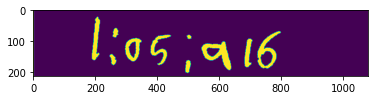

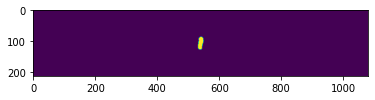

21


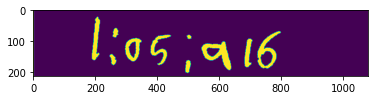

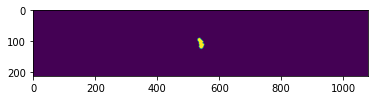

95


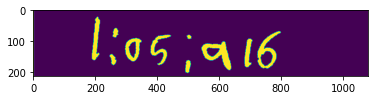

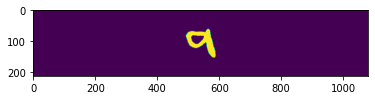

/tmp/ipykernel_17833/1404725269.py:143: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feature == []:


105


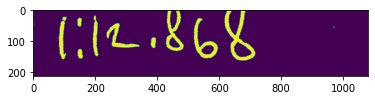

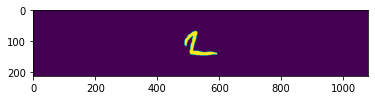

137


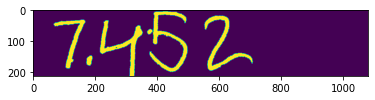

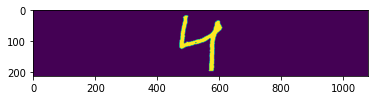

156


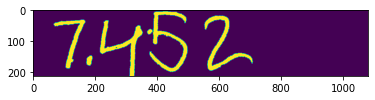

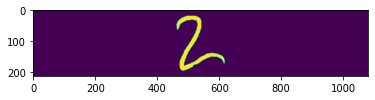

167


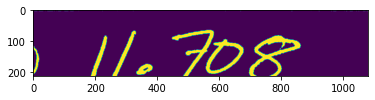

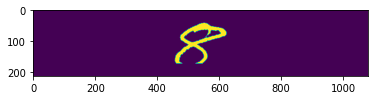

224


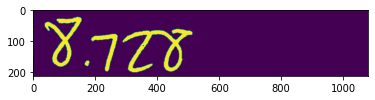

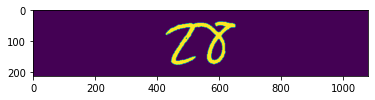

KeyboardInterrupt: 

In [4]:
infile = open("data.csv")

images = []
features = []
labels = []

def process_label(text):
    label = np.zeros(shape=(5,11,))
    if text == "DNF":
        for i in range(5):
            label[i][10] = 1
        return label
    
    if ":" in text:
        label[0][int(text[0])] = 1
    else:
        label[0][0] = 1
    
    seconds = text.split(".")[0]
    if ':' in seconds:
        seconds = seconds.split(':')[1]
    milliseconds = text.split(".")[1]
    
    if len(seconds) == 1:
        label[1][0] = 1
    else:
        label[1][int(seconds[0])] = 1
    
    label[2][int(seconds[-1])] = 1
    label[3][int(milliseconds[0])] = 1
    label[4][int(milliseconds[1])] = 1
    
    return label

def label_to_text(label):
    indecies = []

    for i in label:
        i = list(i)
        indecies.append(str(i.index(max(i))))
    return str(indecies[0] + ":" + indecies[1] + indecies[2] + "." + indecies[3] + indecies[4])
    
def get_contour_info(c):
    left = min(c[:,:,0])[0]
    right = max(c[:,:,0])[0]
    top = min(c[:,:,1])[0]
    bottom = max(c[:,:,1])[0]

    height = (bottom - top)
    width = (right - left)
    
    return left, right, top, bottom, height, width

def shift_diget(rgb, contourimg, shift):
    for y in range(rgb.shape[0]):
        for x in range(rgb.shape[1]):
            if contourimg[y][x]:
                contourimg[y][x] = rgb[y-shift[0]][x-shift[1]]

    return contourimg

maxWidth = -1
digetsWritten = 0

def preprocess(rgb):
    global maxWidth, digetsWritten

    rgb = np.array(rgb)
    rgb = cv2.resize(rgb, (rgb.shape[1]*2, rgb.shape[0]*2))
    
    rgb = np.array(rgb)
    rgb = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    # rgb = 255 - rgb
    # rgb /= 255
    ret, rgb = cv2.threshold(rgb, 210, 255, cv2.THRESH_BINARY_INV)
    rgb /= 255

    for i in range(10):
        if np.mean(rgb[i]) > .65:
            rgb[i] *= 0

    for i in range(10):
        if np.mean(rgb[-i]) > .65:
            rgb[i] *= 0
    
    contours, hi = cv2.findContours(rgb.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # print(contours)

    center = np.array((int((rgb).shape[0]/2), int((rgb).shape[1]/2)))

    unSortedDigets = []

    for con in contours:
        left, right, top, bottom, height, width = get_contour_info(con)
        digetloc = np.array([int((top+bottom)/2), int((left+right)/2)])
        shift = center - digetloc
        
        if height < 5 or width < 5:
            continue

        con[:,:,0] += shift[1]
        con[:,:,1] += shift[0]

        diget = np.zeros(shape=rgb.shape)
        cv2.drawContours(diget, [con], -1, (255,255,255), -1)
        diget = shift_diget(rgb, diget, shift)
        unSortedDigets.append((diget, digetloc, digetloc[1]))

        if width > maxWidth:
            print(width)
            plt.imshow(rgb)
            plt.show()
            plt.imshow(diget)
            plt.show()
            maxWidth = width

    sortedDigets = list(sorted(unSortedDigets, key=itemgetter(2)))
    # plt.imshow(rgb)
    # plt.show()
    # for d in sortedDigets:
    #     plt.imshow(d[0])
    #     plt.show()

    # plt.imshow(rgb)

    for i in sortedDigets:
        diget = i[0]
        outputRef = np.concatenate((rgb, diget))
        plt.imsave("digets/{}.png".format(digetsWritten), outputRef, cmap='gray')
        digetsWritten+=1
    
    feature = np.array(list(i[0].flatten() for i in sortedDigets)).astype(float)
    return feature

progress = 0
for line in infile:
    line = line[0:-1].split(",")
    img = Image.open("imgs/{}.png".format(line[0]))
    feature = preprocess(img)
    label = process_label(line[2])
    
    if feature == []:
        continue
    
    features.append(feature)
    labels.append(label.flatten())
    images.append(img)

    progress+=1
    if progress % 100 == 0:
        print(progress)

    if max(label.flatten()) == 0:
    
        plt.imshow(img)
        plt.show()
        print(line[2])
        continue
    # print(label)
    # print(line[2])
    
    

In [3]:
print(features[0][0].shape)

(106, 540)


In [ ]:
features = np.array(features).astype(float)
labels = np.array(labels).astype(float)

nan_indices_labels = np.argwhere(np.isnan(labels))
if len(nan_indices_labels) > 0:
    print("NaN values found in labels at indices:", nan_indices_labels)
else:
    print("No NaN values found in labels.")

nan_indices_features = np.argwhere(np.isnan(features))
if len(nan_indices_features) > 0:
    print("NaN values found in features at indices:", nan_indices_features)
else:
    print("No NaN values found in features.")


In [22]:
# Define your model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(106, 540, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11*5, activation='softmax'))

# Compile your model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Define mini-batch size
batch_size = 32

# Assuming features and labels are lists of numpy arrays
num_samples = len(features)
num_epochs = 4  # Define the number of epochs

# Training loop with mini-batch processing
for epoch in range(num_epochs):
    print("Epoch:", epoch+1)
    total_loss = 0
    total_accuracy = 0
    
    # Shuffle the data
    indices = np.random.permutation(num_samples)
    shuffled_features = [features[i] for i in indices]
    shuffled_labels = [labels[i] for i in indices]

    # Mini-batch processing
    for i in range(0, num_samples, batch_size):
        batch_features = shuffled_features[i:i+batch_size]
        batch_labels = np.array(shuffled_labels[i:i+batch_size])

        padded_features = np.array(pad_sequences(batch_features, padding='post', dtype='float32'))
        padded_features = padded_features.reshape((padded_features.shape[0], padded_features.shape[1], padded_features.shape[2], padded_features.shape[3], 1))
        # print(padded_features.shape)
        
        print(padded_features.shape, batch_labels.shape)
        
        # Convert features and labels to TensorFlow tensors
        # batch_features = tf.convert_to_tensor(np.array(batch_features), dtype=tf.float32)
        # batch_labels = tf.convert_to_tensor(np.array(batch_labels), dtype=tf.float32)

        # Train the model on the mini-batch
        loss, accuracy = model.train_on_batch(padded_features, batch_labels)
        total_loss += loss
        total_accuracy += accuracy

    # Print average loss and accuracy for the epoch
    average_loss = total_loss / (num_samples / batch_size)
    average_accuracy = total_accuracy / (num_samples / batch_size)
    print("Average Loss:", average_loss)
    print("Average Accuracy:", average_accuracy)

# After training, you can evaluate the model, save it, or use it for predictions

Epoch: 1
(416, 106, 540, 1) (32, 55)


ValueError: Data cardinality is ambiguous:
  x sizes: 416
  y sizes: 32
Make sure all arrays contain the same number of samples.

In [17]:
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.fit(features, labels, epochs=3, validation_split=0.2)

Epoch 1/3
47/77 [=================>............] - ETA: 1s - loss: 0.0753 - accuracy: 0.8590

KeyboardInterrupt: 

In [ ]:
for id, f in enumerate(features):
    # img = f.reshape((540, 106, 1))
    
    pred = model.predict(np.array([f])).reshape((5,11))
    print(label_to_text(pred))
    plt.imshow(images[id])
    plt.show()
